In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

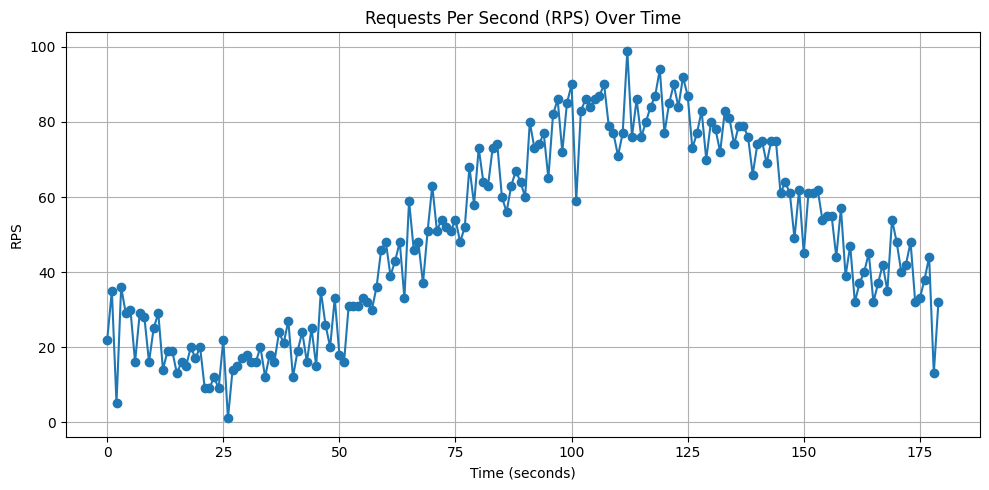

In [89]:
seconds = 180
baseRPS = 50
amplitude = 35
noiseSTD = 7

# Generate time vector
t = np.linspace(0, 2 * np.pi, seconds)

# Sinusoidal pattern + noise
rps = baseRPS + amplitude * np.sin(t - 15) + np.random.normal(0, noiseSTD, seconds)

# Clean it up (no negative RPS)
rps = np.clip(rps, 1, None)

df = pd.DataFrame({'Time': range(seconds), 'RPS': rps.astype(int)})
df.to_csv("workloadProfile.csv", index = False, sep = ';')

# Just to have a visual understanding, let's plot it
plt.figure(figsize = (10, 5))
plt.plot(df['Time'], df['RPS'], marker = 'o')
plt.title('Requests Per Second (RPS) Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('RPS')
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
# This function adjusts the indentation of the generated XML file, just to make it more readable
def indent(elem, level=0):

    i = "\n" + level * "  "
    
    if len(elem):
        
        if not elem.text or not elem.text.strip():
            elem.text = i + "  "
        
        for child in elem:
            indent(child, level+1)
        
        if not child.tail or not child.tail.strip():
            child.tail = i
    
    if level and (not elem.tail or not elem.tail.strip()):
        elem.tail = i

In [84]:
# We update the values of the Concurrency Thread Group (look at the ReadME for a complete explaination of the parameters) 

def writeConcurrencyThread(root, concurrencyValues):

    targetSampler = None

    for elem in root.iter("com.blazemeter.jmeter.threads.concurrency.ConcurrencyThreadGroup"):

        if elem.attrib.get("testname") == "Concurrency Thread Group":
            
            targetSampler = elem
            break


    for child in targetSampler:

        if child.tag == "stringProp":
            
            name = child.attrib.get("name")
        
            if name in concurrencyValues:

                child.text = concurrencyValues[name]

    return root


# We update the values of the HTTP Request format (look at the ReadME for a complete explaination of the parameters) 
def writeHTTPRequest(root, httpValues, jsonBody):

    targetSampler = None

    for elem in root.iter("HTTPSamplerProxy"):

        if elem.attrib.get("testname") == "Matrix Multiply - HTTP Request":
            
            targetSampler = elem
            break

    # Update the domain, port, path and method request
    for child in targetSampler:

        if child.tag == "stringProp":
            
            name = child.attrib.get("name")
        
            if name in httpValues:

                child.text = httpValues[name]

    # Update the request's body
    httpArgumentsProp = None
    for elem in targetSampler.iter("elementProp"):

        if elem.attrib.get("name") == "HTTPsampler.Arguments":
        
            httpArgumentsProp = elem
            break

    if httpArgumentsProp:

        for subelem in httpArgumentsProp.iter("stringProp"):
            
            if subelem.attrib.get("name") == "Argument.value":
            
                subelem.text = jsonBody
                break

    return root


# We update the values for the upload of the CSV file (look at the ReadME for a complete explaination of the parameters) 
def writeCSVFile(root, csvValues, csvBools):

    csvDataset = None

    for elem in root.iter("CSVDataSet"):

        if elem.attrib.get("testname") == "CSV File - Matrices":
        
            csvDataset = elem
            break

    for child in csvDataset:

        name = child.attrib.get("name")
        
        if child.tag == "stringProp" and name in csvValues:
            child.text = csvValues[name]
        
        elif child.tag == "boolProp" and name in csvBools:
            child.text = csvBools[name]

    return root

In [85]:
# Starting from the WorkLoad Profile, since the plug-in does not allow us to import it,
# we generate the actual elements to writes within the jmeter.jmx

def writeWorkload(root, workload, configFile):

    '''
    Format for each entry in the dataframe:

    <collectionProp name="84472748">                 # The name is not important, you can reuse it
        <stringProp name="48">0</stringProp>         # This represents the Initial RPS
        <stringProp name="49">1</stringProp>         # This represents the Final RPS
        <stringProp name="49">1</stringProp>         # This represents the Duration (expressed in seconds)
    </collectionProp>
    '''

    df = pd.read_csv(workload, delimiter = ';')

    duration = 1
    previousRPS = 0

    # Find the target <collectionProp name="load_profile"> (i.e. where we want to insert the workload)
    for elem in root.iter('collectionProp'):
        
        if elem.attrib.get('name') == 'load_profile':
            
            loadProfileElem = elem
            
            break

    # Just to be sure, we remove all the children of that node
    loadProfileElem.clear()
    loadProfileElem.set('name', 'load_profile')


    for index, row in df.iterrows():

        #print(f"Row {index}: Time = {row['Time']}, RPS = {row['RPS']}")
        collection = ET.Element('collectionProp', {'name': '84472748'})
        
        ET.SubElement(collection, 'stringProp', {'name': str(previousRPS)}).text = str(previousRPS)
        ET.SubElement(collection, 'stringProp', {'name': str(row['RPS'])}).text = str(row['RPS'])
        ET.SubElement(collection, 'stringProp', {'name': str(duration)}).text = str(duration)

        loadProfileElem.append(collection)
        previousRPS = row['RPS']

    indent(root)
    
    return root

In [90]:
# File where we have defined the specific workload behaviour
workload = 'workloadProfile.csv'

# Data of the Concurrency Thread Group
concurrencyValues = {

    "TargetLevel": "500",    
    "RampUp": "0",                          
    "Steps": "1",
    "Hold": "3"

}

# Data of the HTTP Request
httpValues = {

    "HTTPSampler.domain": "127.0.0.1",
    "HTTPSampler.port": "80",
    "HTTPSampler.path": "/multiply",
    "HTTPSampler.method": "POST"

}

jsonBody = '''{

    "matrix_a": ${matrix_a},
    "matrix_b": ${matrix_b}

}'''

# Data of the CSV file about the matrices
csvValues = {

    "delimiter": ";",
    "fileEncoding": "US-ASCII",
    "filename": "/Users/fabioschiliro/Desktop/Multidisciplinary Project/MultidisciplinaryProject/JMeter/Matrices.csv",
    "variableNames": "matrix_a,matrix_b",
    "shareMode": "shareMode.all"

}

csvBools = {
    "ignoreFirstLine": "true",
    "quotedData": "false",
    "recycle": "true",
    "stopThread": "false"
}


# Let's create the configuration file now!
configFile = 'jmeterConfigurationFile.jmx'
baseFile = '[Structure] Matrix Multiplication Requests.jmx'

tree = ET.parse(baseFile)
root = tree.getroot()

root = writeConcurrencyThread(root, concurrencyValues)
root = writeHTTPRequest(root, httpValues, jsonBody)
root = writeCSVFile(root, csvValues, csvBools)
root = writeWorkload(root, workload, configFile)

tree.write(configFile, encoding = 'utf-8', xml_declaration = True)
print('File correctly saved!')

File correctly saved!
